# **CS482 Final Project**
### **Written by:** Diane Hamilton and Aadya Kamath
### **Due:** May 13, 2025

## **Topic:** FungiCLEF25 @ CVPR-FGVC & LifeCLEF

##**Overview**
The FungiCLEF Challenge focuses on few-shot recognition of fungi species using real-world observational data. Each observation includes multiple photographs of the same specimen, along with metadata (e.g., location, timestamp, substrate, habitat, toxicity), satellite imagery and meteorological variables.
<p>
The goal of the challenge is to develop a classification model capable of returning a ranked list of predicted species for each observation. A key challenge lies in handling a large number of species consisted of rare and under-recorded taxa with very few training examples.

**Input:** A list of fungi observations.
**Output:** A list of Top-k predicted fungi species from a predefined set of classes.

**Kagle Link**: https://www.kaggle.com/competitions/fungi-clef-2025


# 🔬 **0: Setup Steps**

In this section, we carry out installations that are necessary for performing the tasks we will be performing in this project.

##**📌 Tools to keep in mind**

PyTorch or TensorFlow for modeling

Hugging Face transformers for text

sklearn/pandas for tabular preprocessing

albumentations or timm for data augmentation

Faiss for embedding similarity search (rare species)

In [1]:
#pip install our desired model
#pip install other packages or libraries we need

import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.models import resnet50


In [2]:
# import helpers we built
from constants import *
import load_data
from fungi_dataloader import MultimodalDataset
from model.fusion_model import ProtoNetModel
from fungi_ksampler import EpisodicBatchSampler

##🤔**1: Understand the Problem**

**Goal:** Rank fungi species per observation (i.e., not just top-1 accuracy).

**Challenge:** Many classes (2,000+), most with very few examples (1–4).

**Opportunity:** Rich metadata (temporal, spatial, environmental) and image captions to augment vision data.

Azure Blob Storage Python quickstart sample


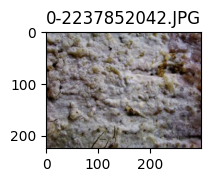

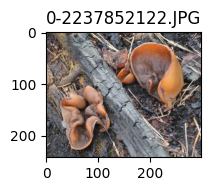

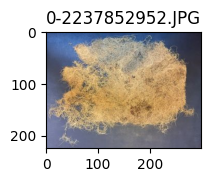

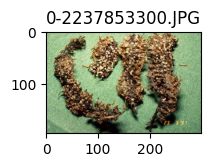

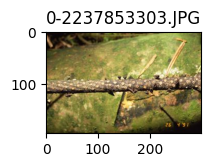

In [3]:
# visualize img data
load_data.preview_data()

In [4]:
# and tabular data
train_metadata = load_data.csv_data("train")
test_metadata = load_data.csv_data("test")
val_metadata = load_data.csv_data("val")

In [5]:
train_metadata

,eventDate,year,month,day,habitat,countryCode,scientificName,kingdom,phylum,class,...,observationID,region,district,filename,category_id,metaSubstrate,poisonous,elevation,landcover,biogeographicalRegion
0,2021-01-24,2021,1.0,24.0,Mixed woodland (with coniferous and deciduous ...,DK,Xylohypha ferruginosa (Corda) S.Hughes,Fungi,Ascomycota,Eurotiomycetes,...,3052832307,Sjælland,Næstved,0-3052832307.JPG,2421,wood,0,0.0,16.0,continental
1,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,3061954303,Hovedstaden,Gribskov,0-3061954303.JPG,386,wood,0,0.0,17.0,continental
2,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,3061954303,Hovedstaden,Gribskov,1-3061954303.JPG,386,wood,0,0.0,17.0,continental
3,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,3061954303,Hovedstaden,Gribskov,2-3061954303.JPG,386,wood,0,0.0,17.0,continental
4,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,3061954303,Hovedstaden,Gribskov,3-3061954303.JPG,386,wood,0,0.0,17.0,continental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7814,2021-12-18,2021,12.0,18.0,Deciduous woodland,DK,Plagiosphaera immersa (Trail) Petr.,Fungi,Ascomycota,Sordariomycetes,...,4100093368,Hovedstaden,Rudersdal,0-4100093368.JPG,1736,plant material,0,93.0,1.0,continental
7815,2021-12-18,2021,12.0,18.0,Deciduous woodland,DK,Plagiosphaera immersa (Trail) Petr.,Fungi,Ascomycota,Sordariomycetes,...,4100093368,Hovedstaden,Rudersdal,2-4100093368.JPG,1736,plant material,0,93.0,1.0,continental
7816,2021-12-30,2021,12.0,30.0,Unmanaged deciduous woodland,DK,Mycobernardia incrustans (Parmasto) Ghobad-Nejhad,Fungi,Basidiomycota,Agaricomycetes,...,3429079314,Sjælland,Sorø,2-3429079314.JPG,1465,wood,0,0.0,17.0,continental
7817,2015-06-28,2015,6.0,28.0,salt meadow,DK,Laboulbenia curtipes Thaxt.,Fungi,Ascomycota,Laboulbeniomycetes,...,4847339663,NaN,NaN,0-4847339663.JPG,1166,animals,0,0.0,17.0,continental


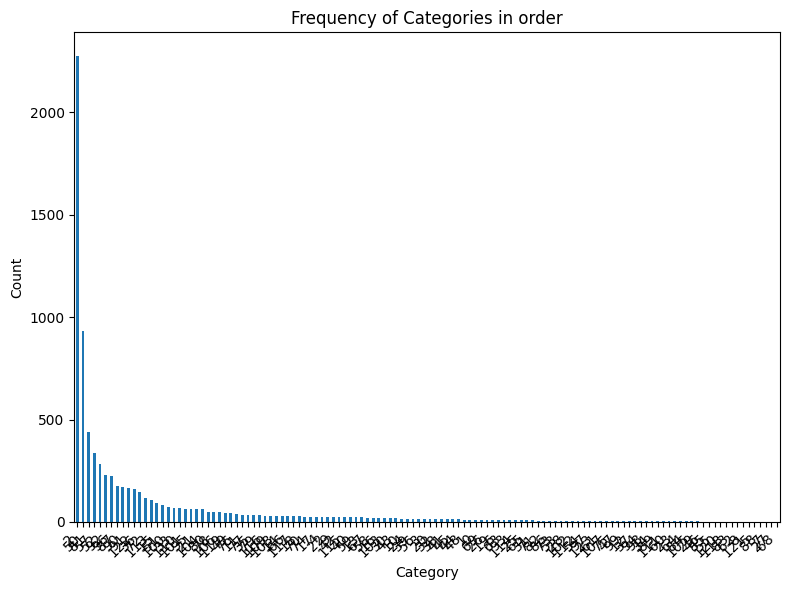

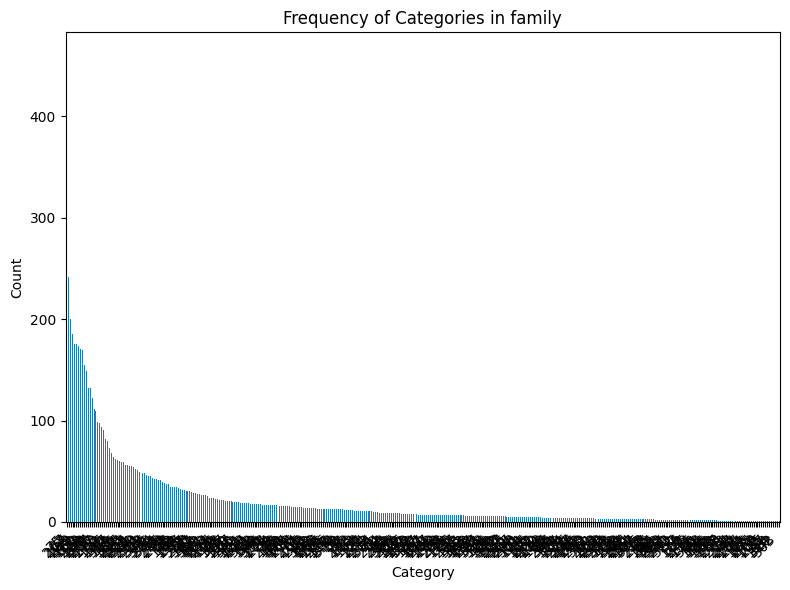

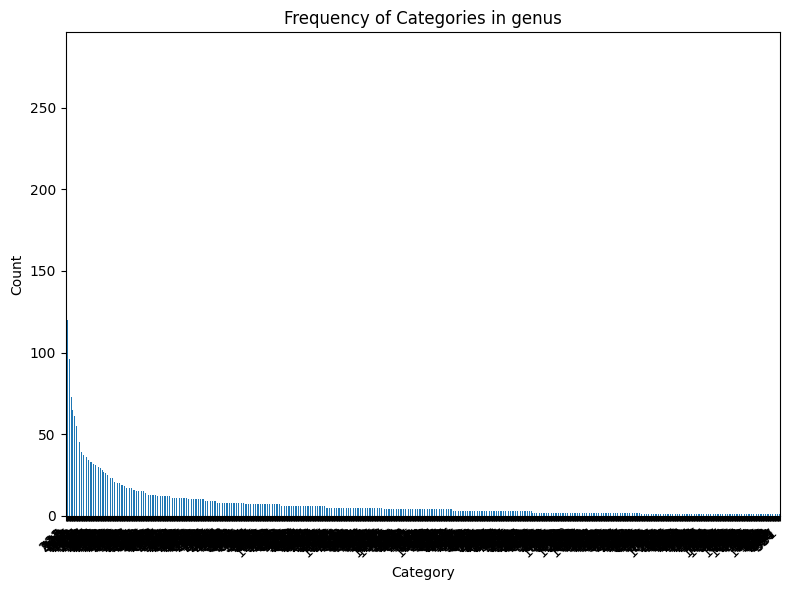

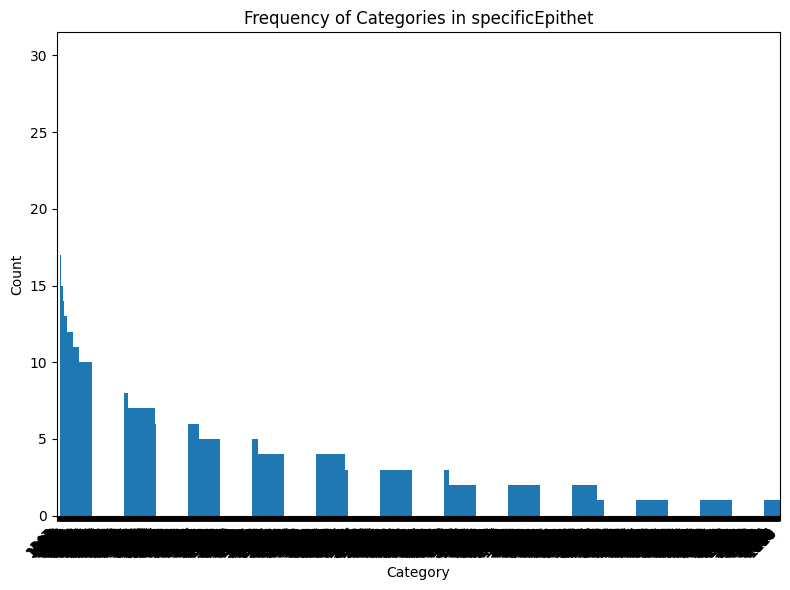

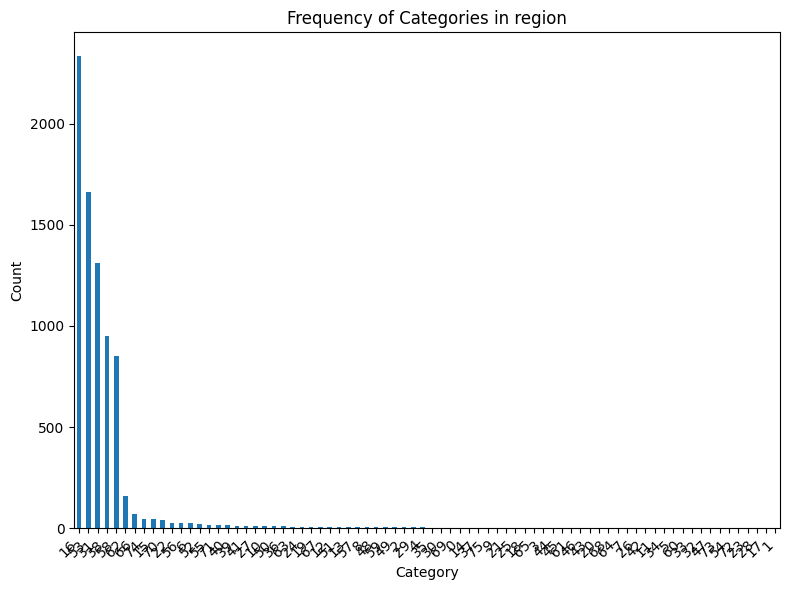

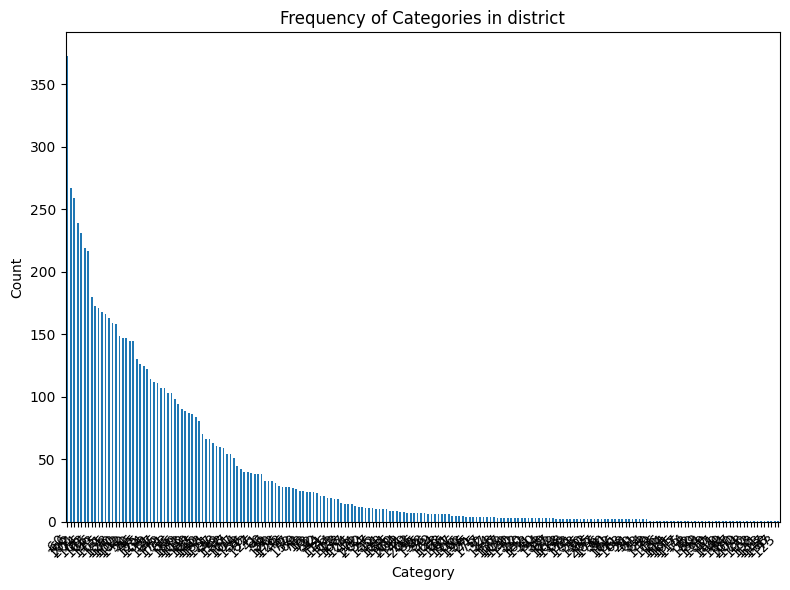

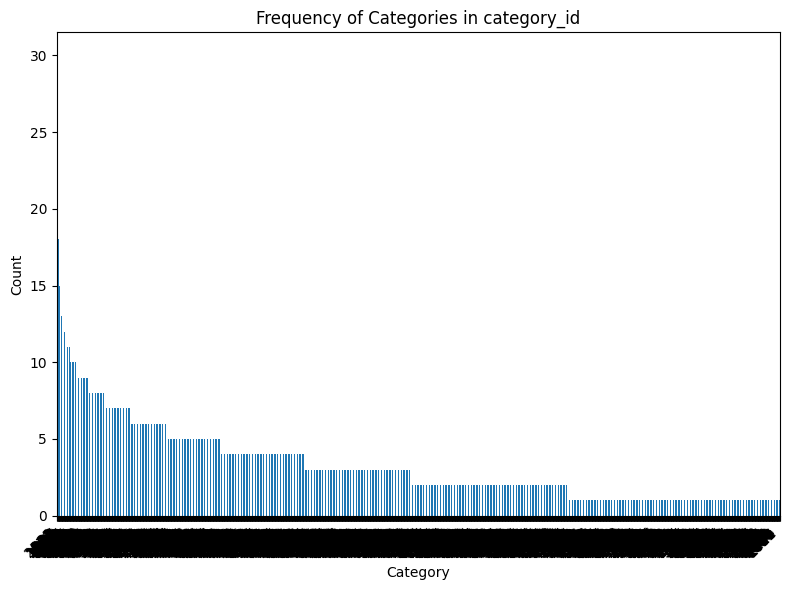

In [6]:
# identify if data is skewed
load_data.visualize_categories('train')

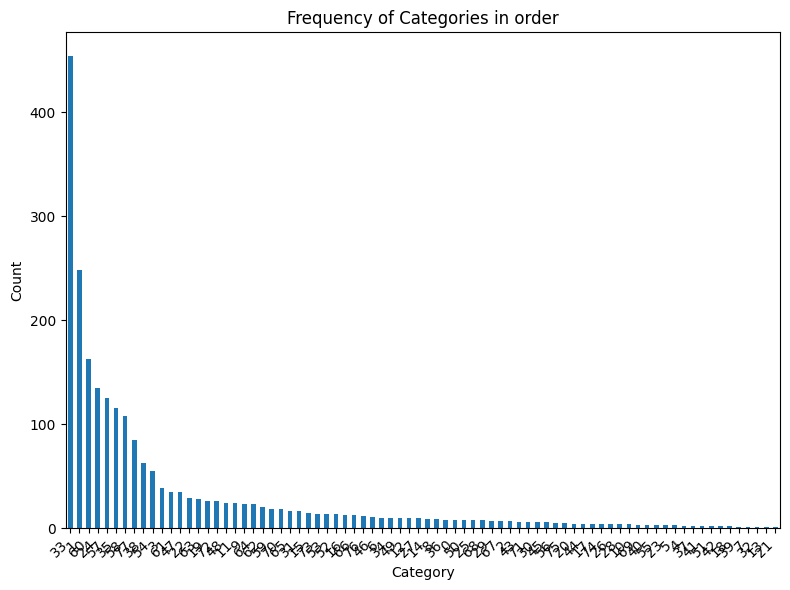

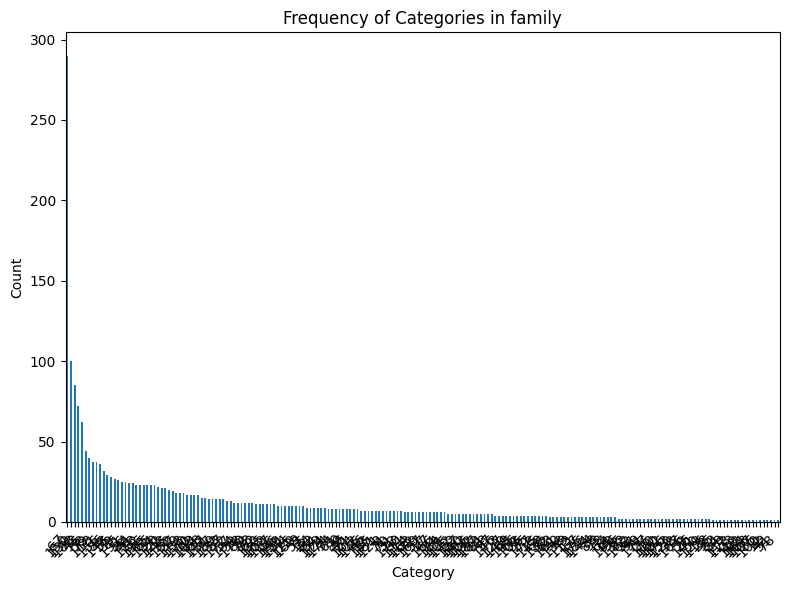

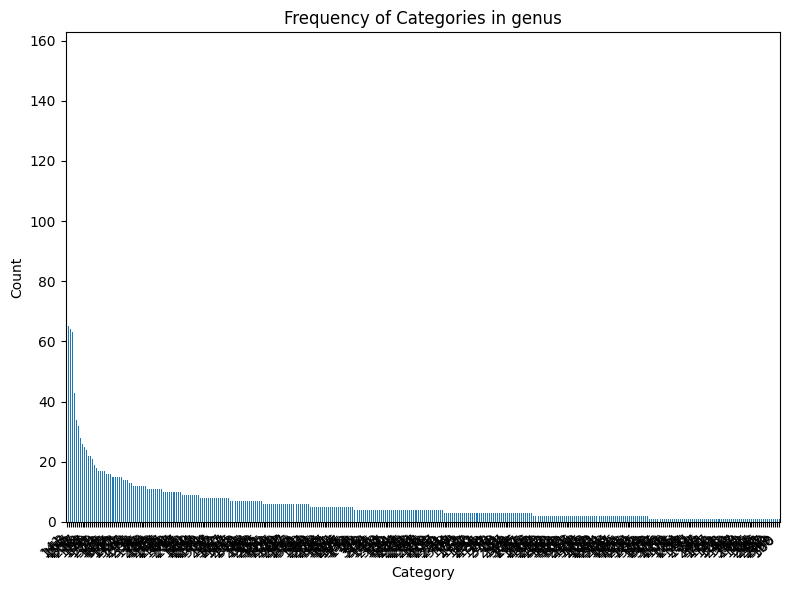

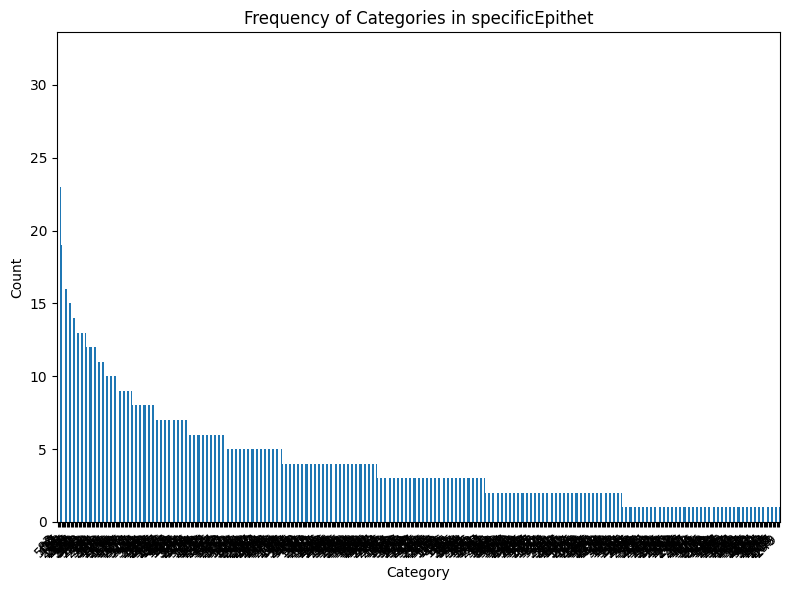

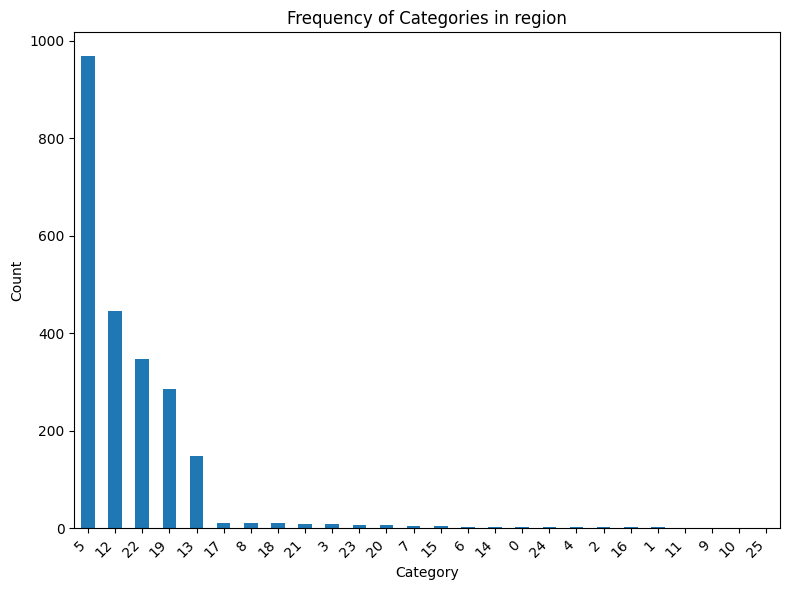

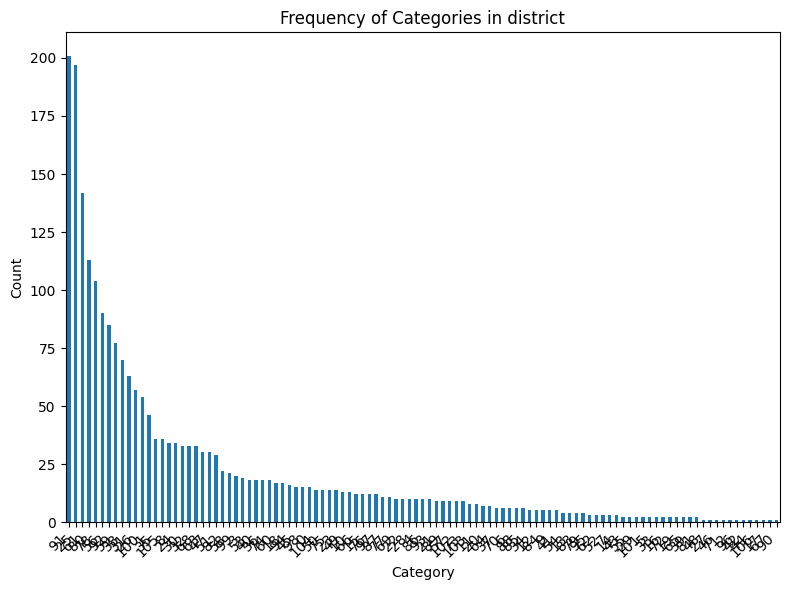

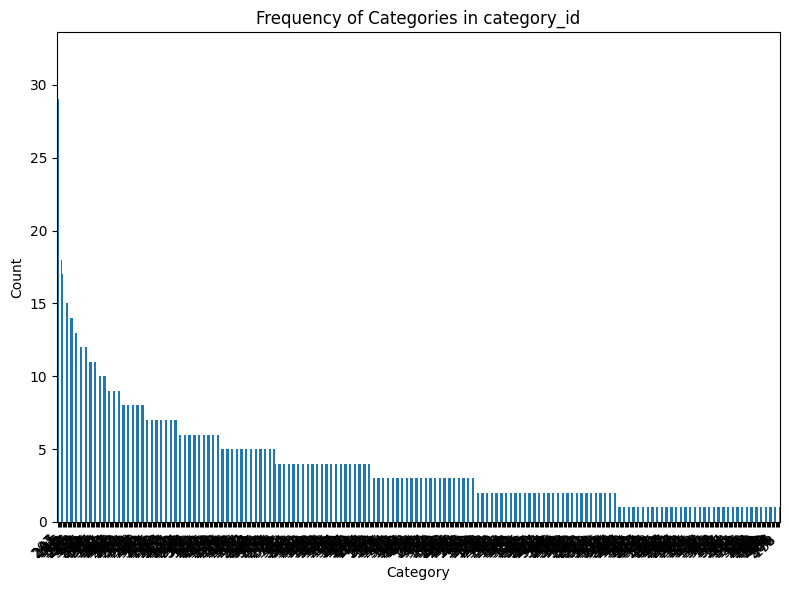

In [7]:
# identify if data is skewed
load_data.visualize_categories('val')

##⛽**2: Preprocess & Explore the Data**

**Image sets:** Start with 300px or 500px images for quicker experimentation.

**Metadata:** Normalize categorical fields (habitat, substrate), encode timestamps (month/day), and parse EXIF features.

**Satellite images & captions:** Treat these as separate input modalities for later fusion.

**Class imbalance:** Compute class frequencies and identify rare classes.

In [3]:
train_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224,224)),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01),
    v2.RandomAffine(degrees=5, translate=(0.02, 0.02), scale=(0.95, 1.05)),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224,224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# perform preprocessing on img data and tabular
ds_train = MultimodalDataset('train',res=500, transform=train_transform)
ds_test = MultimodalDataset('test',res=500, transform=train_transform)
ds_val = MultimodalDataset('val',res=500, transform=test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9602618].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1868412].


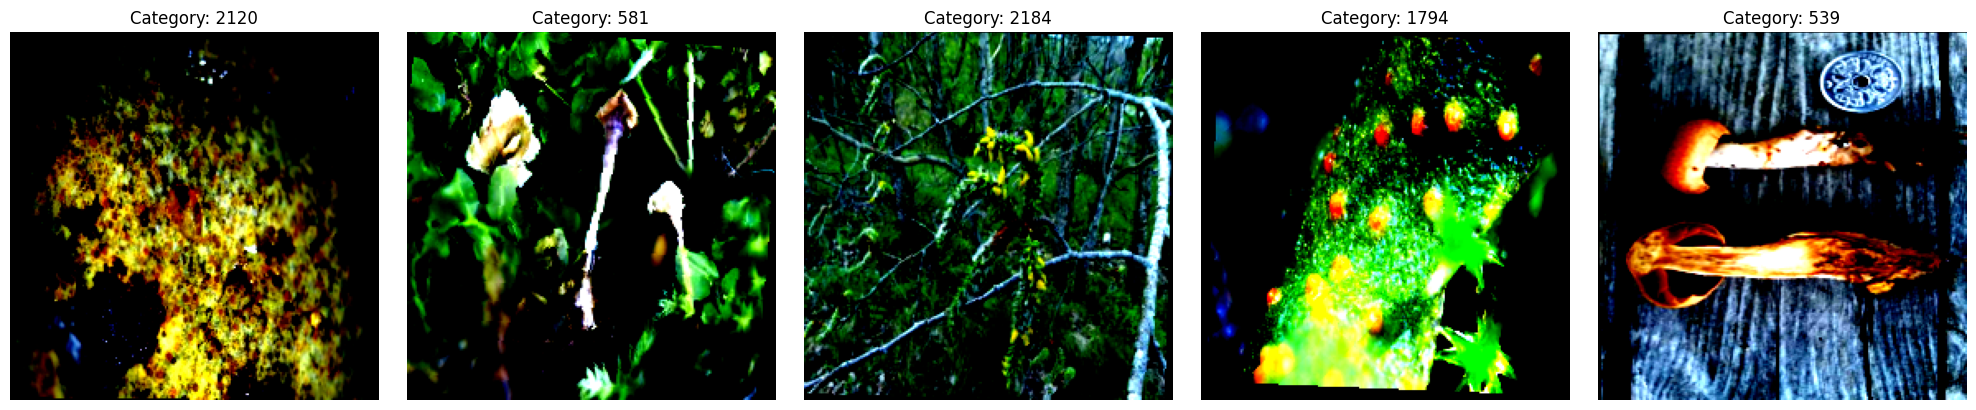

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.3611333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.0125494].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.83543426].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5877128].


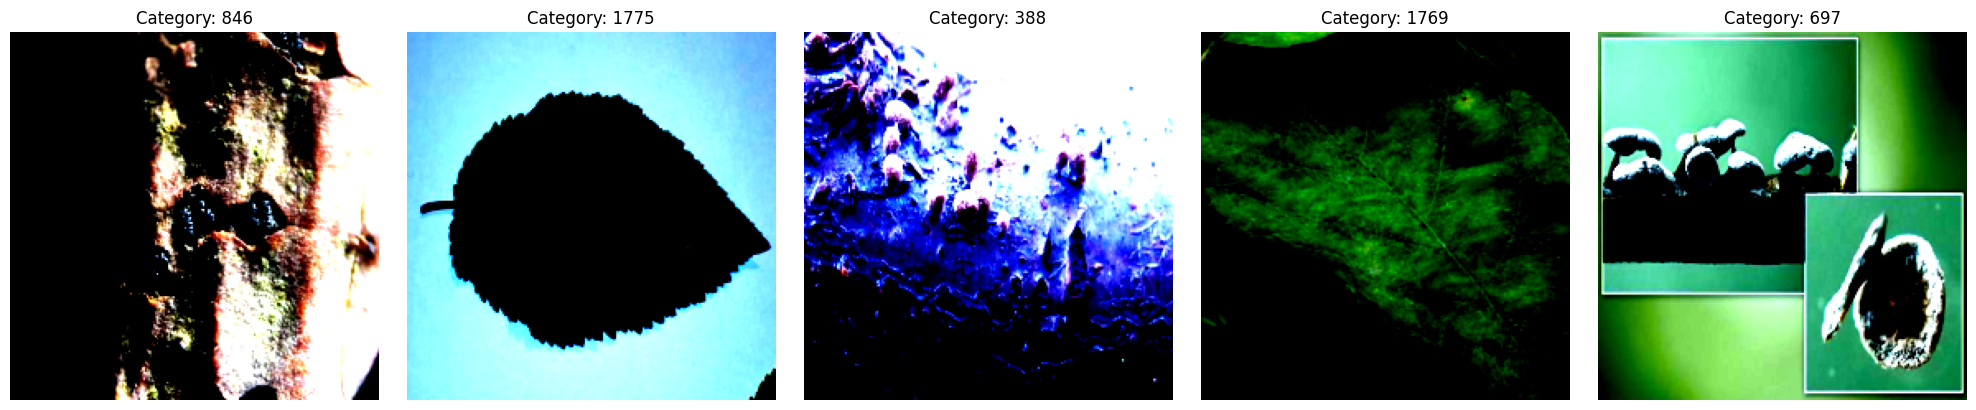

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


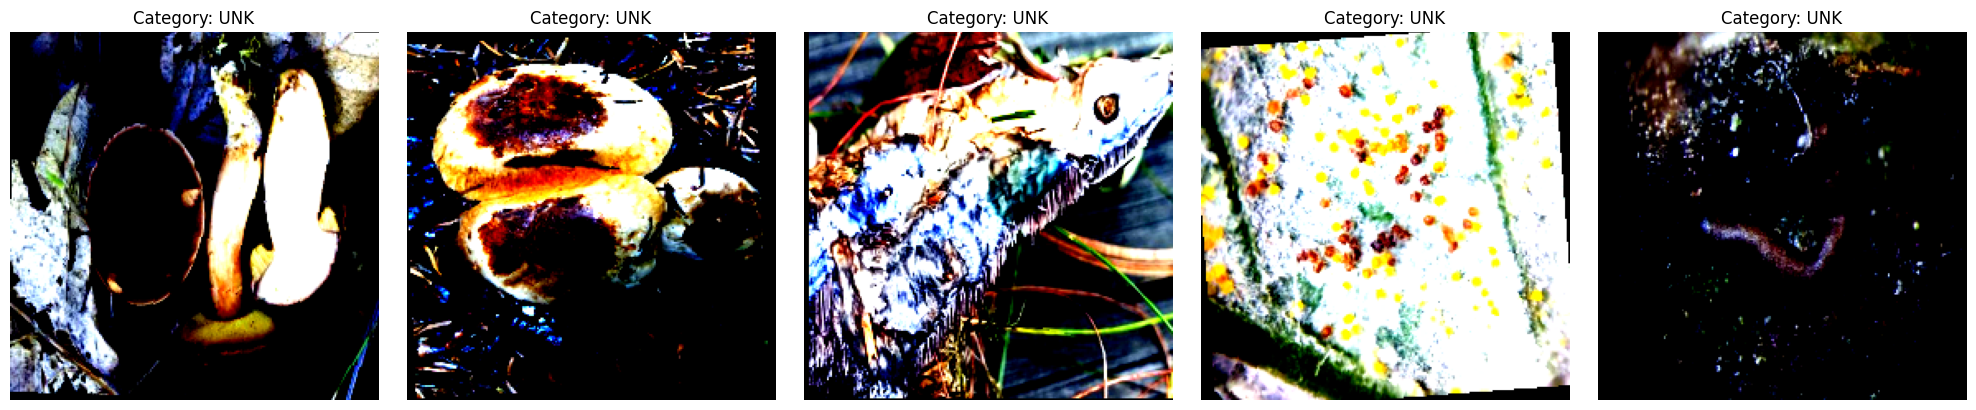

In [4]:
ds_train.visualize_data()
ds_val.visualize_data()
ds_test.visualize_data()

In [5]:
# create train batches
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


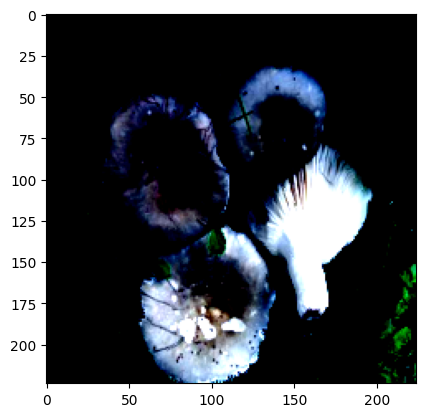

Label: 1998


In [6]:
# Display image and label.
train_features, _, train_labels = next(iter(dl_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img.permute(1, 2, 0).numpy()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
# optionally download data if you really want to
# ds_train.download_dataset()
# ds_test.download_dataset()
# ds_val.download_dataset()

##**3: Base Modeling**

**Image model:** Use a pre-trained image encoder (e.g. EfficientNet, ConvNeXt, or a ViT variant) fine-tuned on your dataset.

**Metadata model:** MLP over tabular features (or transformer if complex). Normalize numerical fields.

**Combine:** Late fusion — combine image and metadata logits before ranking predictions.

**Loss:** Use cross-entropy with class re-weighting or focal loss to boost rare class signal.

In [25]:
# base img encoder model

class MushroomImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        backbone = resnet50(pretrained=True)
        backbone.fc = nn.Linear(backbone.fc.in_features, output_dim)

        self.model = backbone
    # shape: (batch_size, output_dim)
    def forward(self, x):
        return self.model(x)  

In [26]:
# base csv encoder model

class MushroomTabularEncoder(nn.Module):
    # input_dim = num features post-preprocessing of tabular data
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, output_ftr),
            nn.ReLU(),
            nn.Linear(output_ftr, output_dim)
        )
    # shape: (batch_size, output_dim)
    def forward(self, x):
        return self.model(x)

In [27]:
image_encoder = MushroomImageEncoder()
tabular_encoder = MushroomTabularEncoder(len(ds_train.df.columns))

c:\Users\dhami\miniconda3\envs\FungiClef\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dhami\miniconda3\envs\FungiClef\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Classification

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [34]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

model = ProtoNetModel(image_encoder, tabular_encoder, prototype_dim=128)

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 20

# define things for the sampler
dataset=ds_train
num_episodes=20               # Number of episodes per epoch
num_classes_per_episode=5      # 5-way
num_support=1                  # 1-shot
num_query=3                     # 3 query samples per class

In [35]:
# note: inspo from hw6
# batch size edited for 5-way, 1-shot check
# Assuming your MultimodalDataset is instantiated as `train_dataset`
episode_sampler = EpisodicBatchSampler(
    dataset=dataset,
    num_episodes=num_episodes,               # Number of episodes per epoch
    num_classes_per_episode=num_classes_per_episode,      # 5-way
    num_support=num_support,                  # 1-shot
    num_query=num_query                     # 5 query samples per class
)

train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_sampler=episode_sampler,
                                               num_workers=2)

### Training loop

In [32]:
epoch_loss = []
for epoch in range(num_epochs):
    # set model to train mode
    model.train()
    # start out the loss for each epoch
    running_loss = 0.0

    print(f'Epoch {epoch+1} of {num_epochs}')
    for batch_idx, (img, csv, labels) in enumerate(train_loader):
        # get support and query indices as you did with labels
        support_idx = [i for i in range(0, num_episodes, num_support+num_query)]
        query_idx = [i for i in range(num_episodes) if i not in support_idx]

        # extract the corresponding image and tabular data
        query_img = img[query_idx]
        query_csv = csv[query_idx]
        query_lbl = labels[query_idx]

        support_img = img[support_idx]
        support_csv = csv[support_idx]
        support_lbl = labels[support_idx]

        if (device != "cpu"):
            support_img = support_img.to(device)
            support_csv = support_csv.to(device)
            support_lbl = support_lbl.to(device)

            query_img = query_img.to(device)
            query_csv = query_csv.to(device)
            query_lbl = query_lbl.to(device)

        # clear prev loss calc
        optimizer.zero_grad()

        # calc support examples
        support_batch_examples = model(support_img, support_csv)

        # Calculate the prototypes
        prototypes = model.calculate_prototypes(support_lbl, support_batch_examples)

        # Forward pass -- embedding examples
        query_batch_examples = model(query_img, query_csv)

        # calculate query dist from prototypes (centroids)
        dists = model.calculate_distance(query_batch_examples, prototypes)

        # List of class labels in the current episode (from support_lbl ideally)
        class_to_index = {int(cls): idx for idx, cls in enumerate(support_lbl)}

        # Map query labels to episodic indices
        query_lbl_local = torch.tensor([class_to_index[int(lbl.item())] for lbl in query_lbl],dtype=torch.int64)

        # negate for dist classifications 
        dists = -dists

        # Compute the loss of local labels mapped from global labels
        loss = loss_fn(dists, query_lbl_local)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # report the loss periodically over the last X batches 
        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = running_loss / len(train_loader)  # Total loss divided by number of batches
    epoch_loss.append(avg_epoch_loss)  # Save epoch loss for later graphing

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss}")

        

Epoch 1 of 10
Epoch [1/10], Loss: 20.212406039237976
Epoch 2 of 10
Epoch [2/10], Loss: 10.987066388130188
Epoch 3 of 10
Epoch [3/10], Loss: 8.725271117687225
Epoch 4 of 10
Epoch [4/10], Loss: 7.1892491862177845
Epoch 5 of 10
Epoch [5/10], Loss: 4.734859046339989
Epoch 6 of 10
Epoch [6/10], Loss: 4.5896730601787565
Epoch 7 of 10
Epoch [7/10], Loss: 3.688286030292511
Epoch 8 of 10
Epoch [8/10], Loss: 3.3976456046104433
Epoch 9 of 10
Epoch [9/10], Loss: 2.9601871490478517
Epoch 10 of 10
Epoch [10/10], Loss: 2.7228850603103636


##**4: Improve Recall@5 (Core Metric)**

**Multi-label softmax + top-k selection:** Ensure your model predicts scores for all classes, then evaluate Top-5 accuracy.

**Labelling:** Apply label smoothing or mixup to improve generalization.

**Classification:** Use cosine classifier or ArcFace for better separation in embedding space.

In [13]:
# improve recall

##**5: Handling Rare Classes**

**Data augmentation:** Use strong augmentations (RandAugment, CutMix, etc.).

**External data:** Use semi-supervised learning (e.g., pseudo-labeling) if allowed by rules.

***Use class prototypes or nearest neighbor matching from image embeddings to help model similarity across species.*

In [14]:
# rare cases

##**6: Captions & Satellite Data**

**Captions:** Encode using a text transformer (e.g., BERT or CLIP text encoder) and fuse with image features.

**Satellite data:** Use a small CNN or ViT variant to extract environmental embeddings.

**Fusion:** Concatenate embeddings (early fusion) or fuse logits (late fusion). Try attention-based fusion for best performance.

##**7: Train & Validate**

**Stratified sampling for cross-validation:** Ensure rare classes are seen.

**Train:** Train with multi-task loss (e.g., predict both species and toxicity) for auxiliary signal.

**Recall@5:** Evaluate with Recall@5 consistently — this is your main optimization target.



##**8: Submission Pipeline**

For each observation:

Aggregate predictions across multiple images.

Return top-5 ranked species labels.

Format correctly using the sample submission file.